Dependencies

In [32]:
%pip install nltk rouge-score evaluate gensim word-mover-distance transformers POT

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/148.0 kB ? eta -:--:--
     -- ------------------------------------- 10.2/148.0 kB ? eta -:--:--
     ------------------------------- ------ 122.9/148.0 kB 1.4 MB/s eta 0:00:01
     -------------------------------------- 148.0/148.0 kB 1.8 MB/s eta 0:00:00
  Created wheel for word-mover-distance: filename=word_mover_distance-0.0.3-py3-none-any.whl size=4351 sha256=6b63bfd732316a0abcfb69dbf6a7621d72c31e027c9cc17234977b0d4878bf87
  Stored in directory: c:\users\aryam\appdata\local\pip\cache\wheels\5b\a3\b5\b43b98002cc219fbe9079ccd74607977b66146eb829998f6ca
Successfully built word-mover-distance
Note: you may need to restart the kernel to use updated packages.


Import all packages

In [1]:
import nltk
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from evaluate import load
import evaluate
import numpy 
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import torch.nn.functional as F
from nltk.translate.meteor_score import meteor_score
import ot
import gensim.downloader as api
from nltk.corpus import stopwords
from time import time
import os
import numpy as np
import pandas as pd
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
from metrics import distances,eval
import tensorflow as tf

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

C:\Users\aryam\AppData\Roaming\Python\Python311\site-packages\ot\backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aryam\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aryam\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aryam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

ALL Automatic Scorer functions

In [2]:
class Scorers:
    
    # BLEU
    def compute_bleu(self,reference, candidate):
        reference_tokens = nltk.word_tokenize(reference.lower())
        candidate_tokens = nltk.word_tokenize(candidate.lower())

        bleu_1 = sentence_bleu([reference_tokens], candidate_tokens, weights=(1, 0, 0, 0))
        bleu_2 = sentence_bleu([reference_tokens], candidate_tokens, weights=(0.5, 0.5, 0, 0))
        bleu_3 = sentence_bleu([reference_tokens], candidate_tokens, weights=(0.33, 0.33, 0.33, 0))
        bleu_4 = sentence_bleu([reference_tokens], candidate_tokens, weights=(0.25, 0.25, 0.25, 0.25))

        return bleu_1, bleu_2, bleu_3, bleu_4
    
    # ROGUE
    def compute_rouge(self,reference, candidate):
    # Convert reference and candidate sentences to lists of tokens
        reference_tokens = reference.lower().split()
        candidate_tokens = candidate.lower().split()

        scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

        scores = scorer.score(reference, candidate)

        # print(f"ROUGE-1 Precision: {scores['rouge1'].precision:.4f}")
        # print(f"ROUGE-1 Recall: {scores['rouge1'].recall:.4f}")
        # print(f"ROUGE-1 F1-score: {scores['rouge1'].fmeasure:.4f}")

        # print(f"ROUGE-2 Precision: {scores['rouge2'].precision:.4f}")
        # print(f"ROUGE-2 Recall: {scores['rouge2'].recall:.4f}")
        # print(f"ROUGE-2 F1-score: {scores['rouge2'].fmeasure:.4f}")

        # print(f"ROUGE-L Precision: {scores['rougeL'].precision:.4f}")
        # print(f"ROUGE-L Recall: {scores['rougeL'].recall:.4f}")
        # print(f"ROUGE-L F1-score: {scores['rougeL'].fmeasure:.4f}")

        return scores

    # METEOR
    def compute_meteor(self,reference, candidate):

        reference =  nltk.word_tokenize(reference.lower())
        candidate =  nltk.word_tokenize(candidate.lower())

        score = meteor_score([reference], candidate)

        return score

    # WORD MOVERS DISTANCE    
    def compute_wmd(self,sentence_a,sentence_b,model):

        sentence_a = sentence_a.lower().split()
        sentence_b = sentence_b.lower().split()


        stop_words = stopwords.words('english')
        sentence_a = [w for w in sentence_a if w not in stop_words]
        sentence_b = [w for w in sentence_b if w not in stop_words]

        # model = api.load('word2vec-google-news-300')
        distance = model.wmdistance(sentence_a,sentence_b)
        # print(distance)

        return distance
    
    # TRANSLATION ERROR RATE
    def compute_ter(self,reference, candidate):

        ref_tokens = nltk.word_tokenize(reference.lower())
        cand_tokens = nltk.word_tokenize(candidate.lower())

        substitutions = nltk.edit_distance(ref_tokens, cand_tokens)
        deletions = len(ref_tokens) - len(set(ref_tokens) & set(cand_tokens))
        insertions = len(cand_tokens) - len(set(ref_tokens) & set(cand_tokens))

        reference_length = len(ref_tokens)
        ter = (substitutions + deletions + insertions) / reference_length

        return ter

    def compute_perplexity(self,text):
        model = AutoModelForCausalLM.from_pretrained("gpt2")
        tokenizer = AutoTokenizer.from_pretrained("gpt2")
        inputs = tokenizer(text, return_tensors = "pt")
        loss = torch.nn.CrossEntropyLoss() 
        final_loss = model(input_ids = inputs["input_ids"], labels = inputs["input_ids"]).loss
        ppl = torch.exp(final_loss)
        return ppl
        # print(ppl)
        

Save JSON

In [3]:
def save_json(data, filepath=r'new_data.json'):
    with open(filepath, 'w') as fp:
        json.dump(data, fp, indent=4)

Change path to Data 

In [4]:
data = json.load(open(r'data/pairwise_evaluation_w_embeddings.json'))

Compute all Scores for all pairs of data points(Need to run once)

In [5]:
scorer = Scorers()
model = api.load('word2vec-google-news-300')

full_embeddings = np.array([datum['full_embedding'] for datum in data])
writer_summary_embeddings = np.array([datum['writer_summary_embedding'] for datum in data])
llm_summary_embeddings = np.array([datum['llm_summary_embedding'] for datum in data])
writer_distances = distances.linear_regression_distance(full_embeddings, writer_summary_embeddings)
llm_distances = distances.linear_regression_distance(full_embeddings, llm_summary_embeddings)

for i,datum in enumerate(data):

    print('{}/{}'.format(i, len(data)))
    writer_summ = datum['writer_summary']
    llm_summ = datum['text-davinci-002_summary']
    article = datum['article_text']

    bleu_1,bleu_2,bleu_3,bleu_4 = scorer.compute_bleu(article,writer_summ)
    datum['bleu_1_writer'] = bleu_1
    datum['bleu_2_writer'] = bleu_2
    datum['bleu_3_writer'] = bleu_3
    datum['bleu_4_writer'] = bleu_4

    bleu_1,bleu_2,bleu_3,bleu_4 = scorer.compute_bleu(article,llm_summ)
    datum['bleu_1_llm'] = bleu_1
    datum['bleu_2_llm'] = bleu_2
    datum['bleu_3_llm'] = bleu_3
    datum['bleu_4_llm'] = bleu_4

    rogue = scorer.compute_rouge(article,writer_summ)
    datum['rogue_1_writer'] = rogue['rouge1'].fmeasure
    datum['rogue_2_writer'] = rogue['rouge2'].fmeasure
    datum['rogue_L_writer'] = rogue['rougeL'].fmeasure

    rogue = scorer.compute_rouge(article,llm_summ)
    datum['rogue_1_llm'] = rogue['rouge1'].fmeasure
    datum['rogue_2_llm'] = rogue['rouge2'].fmeasure
    datum['rogue_L_llm'] = rogue['rougeL'].fmeasure

    meteor = scorer.compute_meteor(article,writer_summ)
    datum['meteor_writer'] = meteor

    meteor = scorer.compute_meteor(article,llm_summ)
    datum['meteor_llm'] = meteor

    wmd = scorer.compute_wmd(article,writer_summ,model)
    datum['WMD_writer'] = wmd

    wmd = scorer.compute_wmd(article,llm_summ,model)
    datum['WMD_llm'] = wmd

    ter = scorer.compute_ter(article,writer_summ)
    datum['TER_writer'] = ter

    ter = scorer.compute_ter(article,llm_summ)
    datum['TER_llm'] = ter

    cosine_dist = distances.cosine_distance(datum['full_embedding'],datum['writer_summary_embedding'])
    datum['cosine_writer'] = cosine_dist

    cosine_dist = distances.cosine_distance(datum['full_embedding'],datum['llm_summary_embedding'])
    datum['cosine_llm'] = cosine_dist

    datum['lr_dist_writer'] = writer_distances[i]
    datum['lr_dist_llm'] = llm_distances[i]

    perplexity_writer = scorer.compute_perplexity(writer_summ)
    perplexity_llm = scorer.compute_perplexity(llm_summ)
    perp_writer = perplexity_writer.item()
    perp_llm = perplexity_llm.item()
    datum['Writer_Perplexity'] = perp_writer
    datum['LLM_Perplexity'] = perp_llm

save_json(data, r'data/All_Scores.json')


0/599


c:\ProgramData\anaconda3\Lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


1/599
2/599
3/599
4/599
5/599
6/599


c:\ProgramData\anaconda3\Lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


7/599
8/599
9/599
10/599
11/599
12/599
13/599
14/599
15/599
16/599
17/599
18/599
19/599
20/599
21/599
22/599
23/599
24/599
25/599
26/599
27/599
28/599
29/599
30/599
31/599
32/599
33/599
34/599
35/599
36/599
37/599
38/599
39/599
40/599
41/599
42/599
43/599
44/599
45/599
46/599
47/599
48/599
49/599
50/599
51/599
52/599
53/599
54/599
55/599
56/599
57/599
58/599
59/599
60/599
61/599
62/599
63/599
64/599
65/599
66/599
67/599
68/599
69/599
70/599
71/599
72/599
73/599
74/599
75/599
76/599
77/599
78/599
79/599
80/599
81/599
82/599
83/599
84/599
85/599
86/599
87/599
88/599
89/599
90/599
91/599
92/599
93/599
94/599
95/599
96/599
97/599
98/599
99/599
100/599
101/599
102/599
103/599
104/599
105/599
106/599
107/599
108/599
109/599
110/599
111/599
112/599
113/599
114/599
115/599
116/599
117/599
118/599
119/599
120/599
121/599
122/599
123/599
124/599
125/599
126/599
127/599
128/599
129/599
130/599
131/599
132/599
133/599
134/599
135/599
136/599
137/599
138/599
139/599
140/599
141/599
142/599
143/599


In [ ]:
final_data = json.load(open(r'data/All_Scores.json'))

Computing LR distance and deltas between scores(writer-llm)

In [ ]:
full_embeddings = np.array([datum['full_embedding'] for datum in data])
writer_summary_embeddings = np.array([datum['writer_summary_embedding'] for datum in data])
llm_summary_embeddings = np.array([datum['llm_summary_embedding'] for datum in data])

distances_writer = distances.linear_regression_distances(full_embeddings,writer_summary_embeddings)
distances_llm = distances.linear_regression_distances(full_embeddings,llm_summary_embeddings)
for i,datum in enumerate(final_data):
    datum['Delta_LR'] = datum['lr_dist_writer'] - datum['lr_dist_llm']
    datum['Delra_Cosine'] = datum['cosine_writer'] - datum['cosine_llm']
    datum['delta_bleu_1'] = datum['bleu_1_writer'] - datum['bleu_1_llm']
    datum['delta_bleu_2'] = datum['bleu_2_writer'] - datum['bleu_2_llm']
    datum['delta_bleu_3'] = datum['bleu_3_writer'] - datum['bleu_3_llm']
    datum['delta_bleu_4'] = datum['bleu_4_writer'] - datum['bleu_4_llm']
    datum['delta_rogue_1'] = datum['rogue_1_writer'] - datum['rogue_1_llm']
    datum['delta_rogue_2'] = datum['rogue_2_writer'] - datum['rogue_2_llm']
    datum['delta_rogue_L'] = datum['rogue_L_writer'] - datum['rogue_L_llm']
    datum['delta_meteor'] = datum['meteor_writer'] - datum['meteor_llm']
    datum['delta_WMD'] = datum['WMD_writer'] - datum['WMD_llm']
    datum['delta_TER'] = datum['TER_writer'] - datum['TER_llm']

AttributeError: module 'metrics.distances' has no attribute 'linear_regression_distances'

Saving final data for model training. 

In [ ]:
save_json(final_data, r'data/data_model.json')

In [ ]:
final_data = json.load(open(r'data/data_model.json'))

Check Final data 

In [ ]:
df = pd.DataFrame(final_data)

In [7]:
df.columns

Index(['article_id', 'writer_id', 'evaluator_id', 'article_text',
       'writer_summary', 'text-davinci-002_summary', 'overall_writer_better',
       'informative_writer_better', 'full_embedding',
       'writer_summary_embedding', 'llm_summary_embedding', 'lr_dist_writer',
       'lr_dist_llm', 'bleu_1_writer', 'bleu_2_writer', 'bleu_3_writer',
       'bleu_4_writer', 'bleu_1_llm', 'bleu_2_llm', 'bleu_3_llm', 'bleu_4_llm',
       'rogue_1_writer', 'rogue_2_writer', 'rogue_L_writer', 'rogue_1_llm',
       'rogue_2_llm', 'rogue_L_llm', 'meteor_writer', 'meteor_llm',
       'WMD_writer', 'WMD_llm', 'TER_writer', 'TER_llm', 'cosine_writer',
       'cosine_llm', 'Writer_Perplexity', 'LLM_Perplexity', 'LR_writer',
       'LR_llm', 'delta_bleu_1', 'delta_bleu_2', 'delta_bleu_3',
       'delta_bleu_4', 'delta_rogue_1', 'delta_rogue_2', 'delta_rogue_L',
       'delta_meteor', 'delta_WMD', 'delta_TER', 'Delta_LR', 'Delra_Cosine'],
      dtype='object')

Dropping the columns not used for training

In [ ]:
final_data = df.drop(columns=['cosine_writer','cosine_llm','LR_writer','LR_llm','lr_dist_writer','lr_dist_llm','Writer_Perplexity','LLM_Perplexity','writer_id', 'evaluator_id','article_text','writer_summary','text-davinci-002_summary','article_id','bleu_1_writer','bleu_2_writer','bleu_3_writer','bleu_4_writer','bleu_1_llm','bleu_2_llm','bleu_3_llm','bleu_4_llm','rogue_1_writer','rogue_2_writer','rogue_L_writer','rogue_1_llm','rogue_2_llm','rogue_L_llm','meteor_writer','meteor_llm','TER_writer','TER_llm','WMD_writer','WMD_llm'])

In [ ]:
final_data

,overall_writer_better,informative_writer_better,full_embedding,writer_summary_embedding,llm_summary_embedding,delta_bleu_1,delta_bleu_2,delta_bleu_3,delta_bleu_4,delta_rogue_1,delta_rogue_2,delta_rogue_L,delta_meteor,delta_WMD,delta_TER,Delta_LR,Delra_Cosine
0,False,Equally Good,"[-0.007163366, 0.0075295228, -0.022528652, -0....","[-0.0027573644, -0.0059608207, -0.017378185, -...","[-0.017751856, 0.0023727566, -0.016772991, -0....",9.315888e-05,-2.227870e-04,-3.952263e-04,-5.884357e-04,-0.016795,-0.119741,-0.075281,-0.010755,0.102884,0.120482,25.234356,-0.064297
1,False,False,"[0.0064340984, -0.013940546, 0.022131747, -0.0...","[-0.0016521142, -0.024277786, 0.004347165, -0....","[0.003536, -0.0033973965, 0.026843945, -0.0226...",-1.181609e-03,-9.724130e-04,-8.214662e-04,-7.150524e-04,-0.135906,-0.119886,-0.085016,-0.054849,0.122838,0.038934,28.330607,-0.034410
2,Equally Good,Equally Good,"[-0.0070248763, -0.00925884, 0.0027083454, -0....","[-0.024424886, -0.0077787954, -0.0036272286, -...","[-0.021199895, -0.013502783, 0.0009260177, -0....",1.304745e-03,1.048415e-03,8.768482e-04,6.623418e-04,-0.013165,-0.006566,-0.060957,-0.005585,0.098476,0.034384,26.154262,0.000946
3,False,False,"[-0.023462681, -0.024742227, -0.018057255, -0....","[-0.011470091, -0.036104277, -0.009304092, -0....","[-0.027852064, -0.026193894, -0.018356454, -0....",-2.063083e-03,-1.932978e-03,-1.775976e-03,-1.626403e-03,-0.087471,-0.138185,-0.070246,-0.034352,0.057226,0.056566,27.664598,-0.037909
4,False,False,"[0.0010762861, 0.00084113114, 0.0077814907, -0...","[0.00010524096, 0.007291257, 0.010436634, -0.0...","[-0.004452347, 0.0064872345, 0.011028628, -0.0...",1.080080e-05,6.755834e-06,3.990179e-06,2.126423e-06,-0.022163,-0.070873,-0.040980,-0.000067,0.006605,0.042050,25.123670,-0.020341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594,False,False,"[-0.0048403596, -0.01597452, 0.029282175, -0.0...","[-0.012659721, -0.015550625, 0.025793782, -0.0...","[-0.0039800056, -0.0050657564, 0.031451117, -0...",4.242518e-12,2.664889e-12,1.383620e-12,6.944559e-13,0.028901,0.011844,0.021000,0.008115,-0.050421,-0.002553,23.280861,0.013741
595,Equally Good,Equally Good,"[-0.00969115, 0.0142671615, 0.017133743, -0.01...","[-0.02096688, -0.00027541863, 0.0039957105, -0...","[-0.026044741, -0.009718284, 0.012808995, -0.0...",-3.804338e-12,-7.245773e-12,-7.345113e-12,-6.524121e-12,-0.011018,-0.023912,-0.014251,-0.002725,0.081895,0.021180,25.522454,-0.032433
596,True,True,"[0.016982611, -0.0031427317, -0.015396845, -0....","[0.023978898, -0.008586212, -0.002757913, 0.00...","[0.01525739, -0.012522703, -0.022811625, -0.00...",2.485266e-03,1.172490e-03,3.204935e-04,-1.092109e-04,0.022454,-0.043864,-0.015294,0.017959,-0.117015,0.033033,28.171980,-0.015478
597,True,True,"[-0.009644198, -0.0059027453, 0.0016152562, -0...","[-0.005729174, -0.019543953, 0.0024205518, -0....","[0.005884727, -0.0063239825, 0.023203008, -0.0...",1.616343e-04,1.064409e-04,7.318380e-05,5.053922e-05,0.071033,0.002296,0.024982,0.022808,-0.058163,-0.011338,26.752569,0.003635


Changing values to string for Label Encoder. Use this to predict overall_writer_better.

In [ ]:
final_data['overall_writer_better'] = [str(value) for value in final_data['overall_writer_better']]

Changing values to string for Label Encoder. Use this to predict informative_writer_better.

In [ ]:
final_data['informative_writer_better'] = [str(value) for value in final_data['informative_writer_better']]

Using Label Encoder to convert 'True, False and Equally good' to '0, 1, 2'

In [ ]:
encoder = LabelEncoder()
final_data['overall_writer_better'] = encoder.fit_transform(final_data['overall_writer_better'])
final_data['informative_writer_better'] = encoder.fit_transform(final_data['informative_writer_better'])

Change labels to informative_writer_better to predict its values

In [ ]:
X = final_data.drop(columns=['overall_writer_better','full_embedding','writer_summary_embedding','llm_summary_embedding','informative_writer_better'])
labels = final_data['overall_writer_better']

Undersampling the classes except the minority class

In [ ]:
from imblearn.under_sampling import NearMiss

nm = NearMiss()
X_resampled, y_resampled = nm.fit_resample(X, labels)

Using Random Sampler for oversampling the classes that are not the majority

In [ ]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(sampling_strategy = 'not minority',random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, labels)

Using SMOTE for oversampling the classes that are not the majority

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_resampled, y_resampled = smote.fit_resample(X, labels)


Check the values of each class in dataset

In [15]:
y_resampled.value_counts()

overall_writer_better
1    243
0    243
2    243
Name: count, dtype: int64

Normalization

In [16]:
X_scaled = X_resampled.copy()  
for column in X_scaled.columns: 
    X_scaled[column] = (X_scaled[column] - X_scaled[column].mean()) / X_scaled[column].std()   

Correlation between features in dataset

<function matplotlib.pyplot.show(close=None, block=None)>

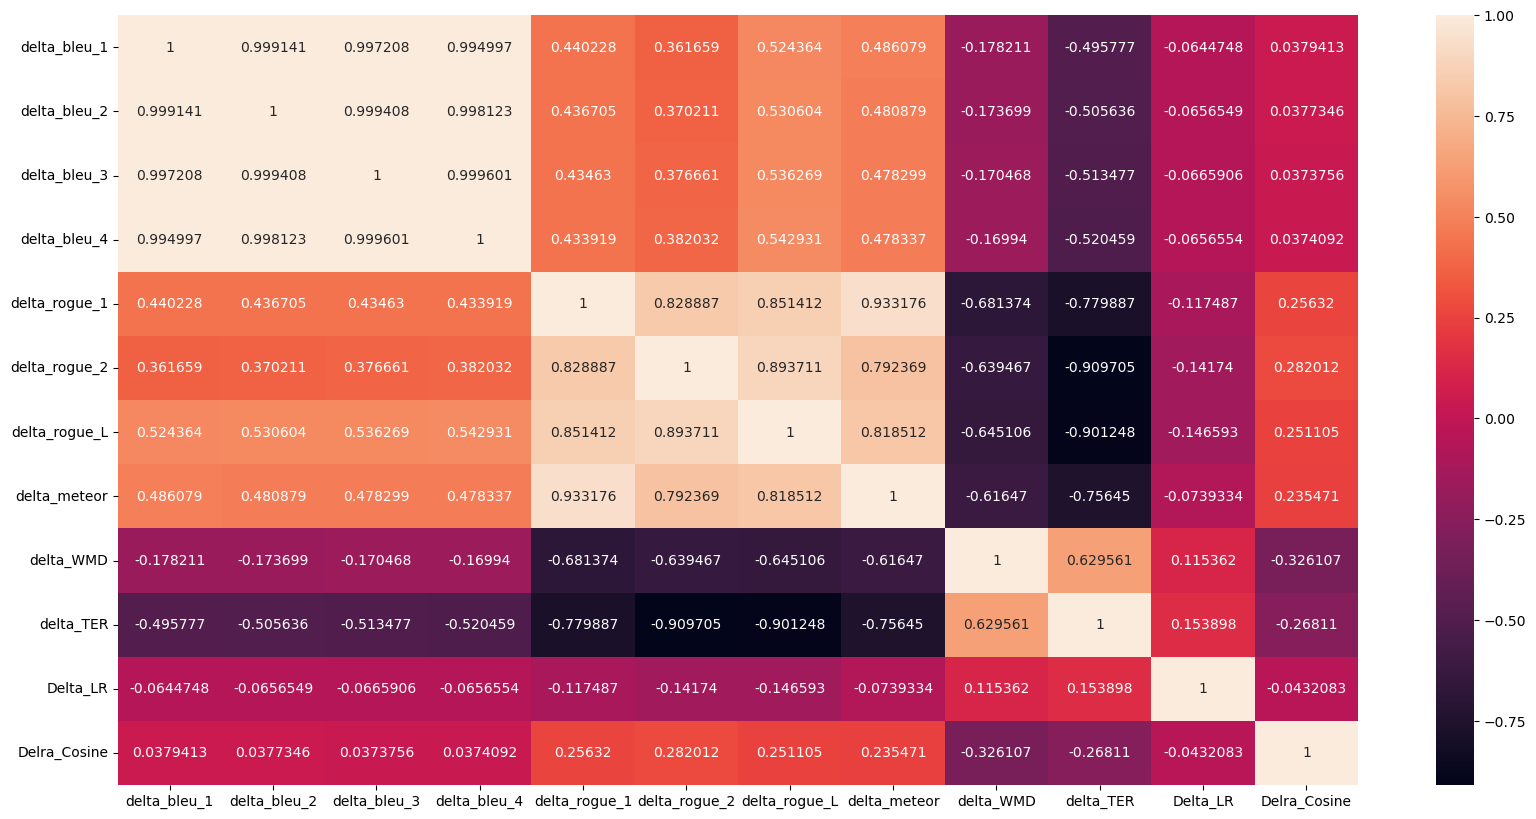

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = X_scaled.corr()

cov_matrix = np.cov(X_scaled, rowvar=False)
plt.figure(figsize=(20, 10))

sns.heatmap(correlation_matrix, annot=True, fmt='g')

plt.show

Train Test and Validation Split

In [ ]:
x, x_test, y, y_test = train_test_split(X_scaled,y_resampled,test_size=0.2,train_size=0.8)
x_train, x_cv, y_train, y_cv = train_test_split(x,y,test_size = 0.25,train_size =0.75)

Final training data

In [ ]:
x_train

,delta_bleu_1,delta_bleu_2,delta_bleu_3,delta_bleu_4,delta_rogue_1,delta_rogue_2,delta_rogue_L,delta_meteor,delta_WMD,delta_TER,Delta_LR,Delra_Cosine
117,0.127446,0.136130,0.144912,0.152465,0.072769,-0.347487,-0.550851,0.169287,0.529019,0.689283,-0.047002,-0.037776
277,0.127441,0.136146,0.144947,0.152518,1.050971,1.129972,1.132414,0.845721,-1.096564,-0.873410,-1.603613,0.667635
409,0.127441,0.136146,0.144947,0.152518,0.768401,1.252505,0.873053,0.808126,-0.888638,-1.211255,0.519692,0.325643
396,0.127441,0.136146,0.144947,0.152518,0.063975,0.380662,0.307888,0.263693,0.788263,-0.246721,0.091911,-0.356707
412,0.129541,0.137671,0.146140,0.153313,0.462460,-0.271511,-0.329194,0.155523,-0.198634,-0.218268,0.764654,0.017568
...,...,...,...,...,...,...,...,...,...,...,...,...
546,0.127441,0.136146,0.144947,0.152518,0.634539,0.573727,0.674922,0.601079,-0.285045,-0.873082,1.011532,-0.307174
713,0.125040,0.134248,0.143571,0.151543,-0.152446,0.142317,0.320059,-0.077480,-0.123264,0.040983,1.424568,0.464287
660,0.139408,0.130778,0.126764,0.127873,-0.084719,-0.359462,-0.377093,0.225844,0.672159,0.307137,0.495641,0.247287
252,0.125443,0.134128,0.142901,0.150408,-1.430164,-1.016950,-1.274761,-1.578045,1.873393,0.719914,0.248330,-2.815674


Final Labels

In [ ]:
labels

0      1
1      1
2      0
3      1
4      1
      ..
594    1
595    0
596    2
597    2
598    2
Name: overall_writer_better, Length: 599, dtype: int32

KNN Classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 6,metric = 'minkowski', p = 2)
knn.fit(x_train, y_train)

y_pred_knn = knn.predict(x_test)
cm_knn = confusion_matrix(y_test, y_pred_knn)
print (cm_knn)
acc_knn = accuracy_score(y_test, y_pred_knn)
print (acc_knn)

[[10  4  5]
 [ 8  8 14]
 [11  3  8]]
0.36619718309859156


SVM

In [ ]:
from sklearn.svm import SVC

svc_rbf = SVC(kernel = 'linear', random_state = 0)
svc_rbf.fit(x_train, y_train)
y_pred_svc_rbf = svc_rbf.predict(x_test)

cm_svc = confusion_matrix(y_test, y_pred_svc_rbf)
print (cm_svc)
acc_svc_rbf = accuracy_score(y_test, y_pred_svc_rbf)
print (acc_svc_rbf)


[[ 7  3  9]
 [ 4  7 19]
 [ 6  5 11]]
0.352112676056338


Naive-Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(x_train, y_train)
y_pred = nb.predict(x_test)

cm_nb = confusion_matrix(y_test, y_pred)
print(cm_nb)
acc_nb = accuracy_score(y_test, y_pred)
print(acc_nb)

[[ 4  0 15]
 [ 0  0 30]
 [ 1  1 20]]
0.3380281690140845


Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
dt.fit(x_train, y_train)
y_pred = dt.predict(x_test)

cm_dt = confusion_matrix(y_test, y_pred)
print (cm_dt)
acc_dt = accuracy_score(y_test, y_pred)
print (acc_dt)


[[11  6  2]
 [12 10  8]
 [12  4  6]]
0.38028169014084506


Random Forest Classifier with grid search for hyperparameter tuning

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier()
param_grid = {
    'n_estimators': range(50, 1000, 50),  # [50, 100, 150]
    'max_depth': np.arange(0, 50, 1),  # [10, 20, ..., 90]
    'min_samples_split': np.linspace(0.1, 1.0, 10, endpoint=True),  # [0.1, 0.2, ..., 1.0]
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(x_train,y_train)

best_params = grid_search.best_params_
print("Best parameters:", best_params)


best_score = grid_search.best_score_
print("Best score:", best_score)

y_pred = grid_search.predict(x_test)


cm_rf = confusion_matrix(y_test, y_pred)
print(cm_rf)

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
1140 fits failed out of a total of 57000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1140 fits failed with the following error:
Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py", line 340, in fit
    self._validate_params()
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "c:\ProgramData\anaconda3\Lib\site-

Best parameters: {'bootstrap': False, 'max_depth': 44, 'min_samples_split': 0.30000000000000004, 'n_estimators': 100}
Best score: 0.5353960006298221
[[39  2  7]
 [18 24  3]
 [19 13 21]]


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.41864273 0.43462447 0.43004251]
  warnings.warn(


Random forest without Hyperparameter tuning

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42,class_weight=None)
rf.fit(x_train, y_train)

y_pred = rf.predict(x_test)
accuracy = rf.score(x_test, y_test)

cm_rf = confusion_matrix(y_test, y_pred)
print (cm_rf)

print('Accuracy:', accuracy)

[[ 6  4  9]
 [ 6 10 14]
 [ 9  4  9]]
Accuracy: 0.352112676056338


AdaBoost Classifier

In [34]:
from sklearn.ensemble import AdaBoostClassifier

abc = AdaBoostClassifier()
abc.fit(x_train, y_train)

y_pred_abc = abc.predict(x_test)
cm_ada = confusion_matrix(y_test, y_pred_abc)
print (cm_ada)
acc_abc = accuracy_score(y_test, y_pred_abc)
print (acc_abc)

[[ 9  3  7]
 [ 9 10 11]
 [ 9  3 10]]
0.4084507042253521


Quadratic discriminant analysis

In [35]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

qda = QuadraticDiscriminantAnalysis()
qda.fit(x_train, y_train)

y_pred_qda = qda.predict(x_test)
cm_qda = confusion_matrix(y_test, y_pred_qda)
print (cm_qda)
acc_qda = accuracy_score(y_test, y_pred_qda)
print (acc_qda)

[[ 6  5  8]
 [ 1 20  9]
 [ 2 14  6]]
0.4507042253521127


MLP Classifier with Hyperparameter tuning

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier()
mlp.fit(x_train, y_train)

param_grid = {
    'hidden_layer_sizes': [(i,) for i in range(50, 1000, 50)],  # [(50,), (100,), (150,)]
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': np.linspace(0.0001, 1, 5),  # [0.0001, 0.012575, 0.02505, 0.037525, 0.05]
    'learning_rate': ['constant','adaptive'],
}

grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(x_train,y_train)

best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Get the best score
best_score = grid_search.best_score_
print("Best score:", best_score)

y_pred = grid_search.predict(x_test)

# Get the confusion matrix
cm_mlp1 = confusion_matrix(y_test, y_pred)
print(cm_mlp1)


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Best parameters: {'activation': 'relu', 'alpha': 0.7500249999999999, 'hidden_layer_sizes': (700,), 'learning_rate': 'adaptive', 'solver': 'adam'}
Best score: 0.4987403558494725
[[39  4  5]
 [21 23  1]
 [20 12 21]]


MLP Classifier without Hyperparameter tuning

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(alpha=0.01, max_iter=1000)
mlp.fit(x_train, y_train)

y_pred_mlp = mlp.predict(x_test)
cm = confusion_matrix(y_test, y_pred_mlp)
print (cm)
acc_mlp = accuracy_score(y_test, y_pred_mlp)
print (acc_mlp)


[[ 7  3  9]
 [ 6  8 16]
 [ 7  5 10]]
0.352112676056338


Linear Regression with Softmax

Epoch 1/200
44/44 [==============================] - 1s 1ms/step - loss: 1.2151 - accuracy: 0.2883
Epoch 2/200
44/44 [==============================] - 0s 1ms/step - loss: 1.1405 - accuracy: 0.3021
Epoch 3/200
44/44 [==============================] - 0s 1ms/step - loss: 1.1011 - accuracy: 0.3272
Epoch 4/200
44/44 [==============================] - 0s 2ms/step - loss: 1.0787 - accuracy: 0.4005
Epoch 5/200
44/44 [==============================] - 0s 1ms/step - loss: 1.0626 - accuracy: 0.4188
Epoch 6/200
44/44 [==============================] - 0s 1ms/step - loss: 1.0494 - accuracy: 0.4531
Epoch 7/200
44/44 [==============================] - 0s 1ms/step - loss: 1.0408 - accuracy: 0.4439
Epoch 8/200
44/44 [==============================] - 0s 2ms/step - loss: 1.0329 - accuracy: 0.4645
Epoch 9/200
44/44 [==============================] - 0s 1ms/step - loss: 1.0266 - accuracy: 0.4622
Epoch 10/200
44/44 [==============================] - 0s 1ms/step - loss: 1.0230 - accuracy: 0.4645
Epoch 11/

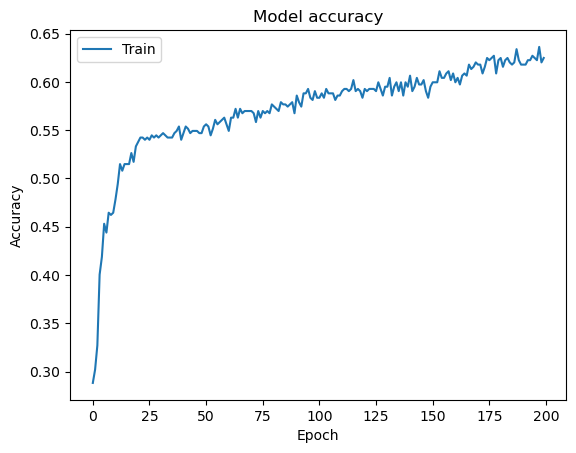

5/5 - 0s - loss: 1.0069 - accuracy: 0.5548 - 90ms/epoch - 18ms/step

Test accuracy: 0.5547945499420166


In [42]:
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
# from keras.wrappers.scikit_learn import KerasClassifier


param_grid = {
    'epochs':np.linspace(50, 300, 6) ,  # [(50,), (100,), (150,)]
    'batch_size': np.linspace(1, 100, 10)
}

# def create_model():
#     model = Sequential()
#     model.add(Dense(10, input_dim=8, activation='relu'))
#     model.add(Dense(10, activation='relu'))
#     model.add(Dense(3, activation='softmax'))
#     model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#     return model

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_dim=x_train.shape[1], activation='relu'),
    # tf.keras.layers.Dense(100, activation='relu'),
    # tf.keras.layers.Dense(100, input_dim=x_train.shape[1], activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax') 
])
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01,momentum=0.5)

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# model = KerasClassifier(build_fn=create_model, verbose=0)

# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1)
# history = grid_search.fit(x_train,y_train)

history = model.fit(x_train, y_train, epochs=200, batch_size=10)

weights = model.layers[0].get_weights()[0]
print(weights)

for layer in model.layers:
    weights = layer.get_weights()
    print(f'Weights for layer {layer.name}: {weights}')


plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)
print(f'\nTest accuracy: {test_accuracy}')



In [ ]:
for feature, avg_weight in zip(list(x_train.columns), average_abs_weights):
    print(f"{feature}: {average_abs_weights}")

MLP with PCA

Epoch 1/200
44/44 [==============================] - 0s 1ms/step - loss: 1.2645 - accuracy: 0.2700
Epoch 2/200
44/44 [==============================] - 0s 1ms/step - loss: 1.1284 - accuracy: 0.3387
Epoch 3/200
44/44 [==============================] - 0s 1ms/step - loss: 1.0722 - accuracy: 0.4005
Epoch 4/200
44/44 [==============================] - 0s 1ms/step - loss: 1.0541 - accuracy: 0.4508
Epoch 5/200
44/44 [==============================] - 0s 1ms/step - loss: 1.0392 - accuracy: 0.4828
Epoch 6/200
44/44 [==============================] - 0s 1ms/step - loss: 1.0287 - accuracy: 0.4943
Epoch 7/200
44/44 [==============================] - 0s 1ms/step - loss: 1.0199 - accuracy: 0.4989
Epoch 8/200
44/44 [==============================] - 0s 1ms/step - loss: 1.0138 - accuracy: 0.5011
Epoch 9/200
44/44 [==============================] - 0s 2ms/step - loss: 1.0082 - accuracy: 0.5080
Epoch 10/200
44/44 [==============================] - 0s 1ms/step - loss: 1.0033 - accuracy: 0.5149
Epoch 11/

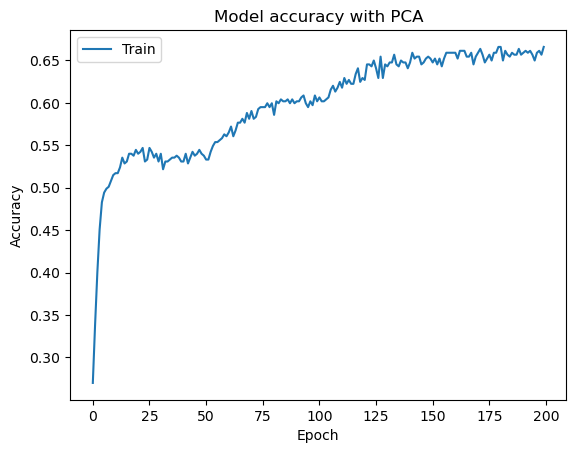

Explained variance ratio:  [6.20346516e-01 2.18185001e-01 6.63511542e-02 3.52634292e-02
 2.80066029e-02 1.36951086e-02 7.50297752e-03 5.77132065e-03
 4.54245707e-03 3.27637970e-04 7.23122800e-06 5.63492401e-07]
5/5 - 0s - loss: 1.0254 - accuracy: 0.5137 - 106ms/epoch - 21ms/step

Test accuracy: 0.5136986374855042


In [40]:
from sklearn.decomposition import PCA

pca = PCA(n_components=x_train.shape[1])
pca.fit(x_train)

X_train_pca = pca.transform(x_train)
X_test_pca = pca.transform(x_test)

model_pca = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_dim=x_train.shape[1], activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'), 
    tf.keras.layers.Dense(3, activation='softmax')  
])

model_pca.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_pca = model_pca.fit(x_train, y_train, epochs=200, batch_size=10)

print("Shape of components_: ", pca.components_.shape)


for i, component in enumerate(pca.components_):
    print(f"Component {i+1}:")
    for feature, weight in zip(list(x_train.columns), component):
        print(f"{feature}: {weight}")

# average_weights = np.mean(pca.components_, axis=0)

# print(pca.components_)

# for feature, avg_weight in zip(list(x_train.columns), average_weights):
#     print(f"{feature}: {avg_weight}")

plt.plot(history_pca.history['accuracy'])
plt.title('Model accuracy with PCA')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

print('Explained variance ratio: ', pca.explained_variance_ratio_)

test_loss, test_accuracy = model_pca.evaluate(x_test, y_test, verbose=2)
print(f'\nTest accuracy: {test_accuracy}')

PCA and LR

In [28]:
from sklearn.decomposition import PCA

pca = PCA(n_components=x_train.shape[1])
pca.fit(x_train)

X_train_pca = pca.transform(x_train)
X_test_pca = pca.transform(x_test)

abs_weights = np.abs(pca.components_)

average_abs_weights = np.mean(abs_weights, axis=0)

# print(average_abs_weights)

sorted_feature_indices = np.argsort(average_abs_weights)

least_important_features = sorted_feature_indices[:3]

print("3 Least important features:")
features = list(x_train)
for i in least_important_features:
    print(features[i])




3 Least important features:
Delta_LR
Delra_Cosine
delta_WMD


In [29]:
X_train_reduced = x_train.drop(columns = ['delta_WMD','Delra_Cosine','Delta_LR'])
X_test_reduced = x_test.drop(columns = ['delta_WMD','Delra_Cosine','Delta_LR'])

In [30]:
print(features)

['delta_bleu_1', 'delta_bleu_2', 'delta_bleu_3', 'delta_bleu_4', 'delta_rogue_1', 'delta_rogue_2', 'delta_rogue_L', 'delta_meteor', 'delta_WMD', 'delta_TER', 'Delta_LR', 'Delra_Cosine']


In [30]:
X_train_reduced

,delta_bleu_1,delta_bleu_2,delta_bleu_3,delta_bleu_4,delta_rogue_1,delta_rogue_2,delta_rogue_L,delta_meteor,delta_TER
117,0.127446,0.136130,0.144912,0.152465,0.072769,-0.347487,-0.550851,0.169287,0.689283
277,0.127441,0.136146,0.144947,0.152518,1.050971,1.129972,1.132414,0.845721,-0.873410
409,0.127441,0.136146,0.144947,0.152518,0.768401,1.252505,0.873053,0.808126,-1.211255
396,0.127441,0.136146,0.144947,0.152518,0.063975,0.380662,0.307888,0.263693,-0.246721
412,0.129541,0.137671,0.146140,0.153313,0.462460,-0.271511,-0.329194,0.155523,-0.218268
...,...,...,...,...,...,...,...,...,...
546,0.127441,0.136146,0.144947,0.152518,0.634539,0.573727,0.674922,0.601079,-0.873082
713,0.125040,0.134248,0.143571,0.151543,-0.152446,0.142317,0.320059,-0.077480,0.040983
660,0.139408,0.130778,0.126764,0.127873,-0.084719,-0.359462,-0.377093,0.225844,0.307137
252,0.125443,0.134128,0.142901,0.150408,-1.430164,-1.016950,-1.274761,-1.578045,0.719914


Epoch 1/300
44/44 [==============================] - 0s 1ms/step - loss: 1.0569 - accuracy: 0.4233
Epoch 2/300
44/44 [==============================] - 0s 1ms/step - loss: 1.0395 - accuracy: 0.4874
Epoch 3/300
44/44 [==============================] - 0s 1ms/step - loss: 1.0318 - accuracy: 0.4805
Epoch 4/300
44/44 [==============================] - 0s 1ms/step - loss: 1.0235 - accuracy: 0.4760
Epoch 5/300
44/44 [==============================] - 0s 1ms/step - loss: 1.0166 - accuracy: 0.4851
Epoch 6/300
44/44 [==============================] - 0s 1ms/step - loss: 1.0105 - accuracy: 0.4897
Epoch 7/300
44/44 [==============================] - 0s 1ms/step - loss: 1.0056 - accuracy: 0.4989
Epoch 8/300
44/44 [==============================] - 0s 1ms/step - loss: 1.0007 - accuracy: 0.5126
Epoch 9/300
44/44 [==============================] - 0s 1ms/step - loss: 0.9975 - accuracy: 0.5217
Epoch 10/300
44/44 [==============================] - 0s 1ms/step - loss: 0.9933 - accuracy: 0.5240
Epoch 11/

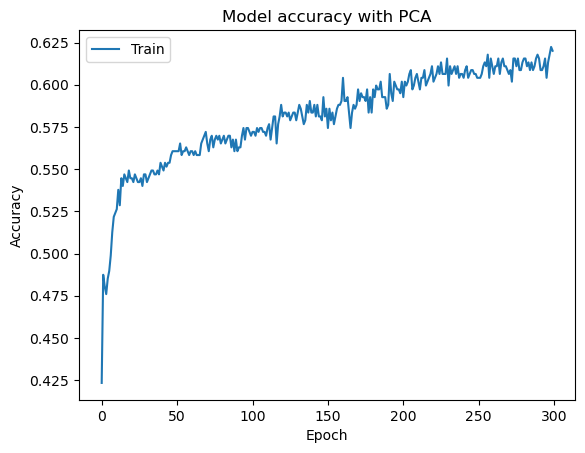

Explained variance ratio:  [7.19478054e-01 2.23118050e-01 3.47378048e-02 9.27526511e-03
 7.14184165e-03 5.80364568e-03 4.35639467e-04 8.98745660e-06
 7.12195324e-07]
5/5 - 0s - loss: 1.0397 - accuracy: 0.5068 - 94ms/epoch - 19ms/step

Test accuracy: 0.5068492889404297


In [38]:
from sklearn.decomposition import PCA

pca = PCA(n_components=X_train_reduced.shape[1])
pca.fit(X_train_reduced)

X_train_pca = pca.transform(X_train_reduced)
X_test_pca = pca.transform(X_test_reduced)

model_pca = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_dim=X_train_reduced.shape[1], activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'), 
    tf.keras.layers.Dense(3, activation='softmax')  
])

model_pca.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_pca = model_pca.fit(X_train_reduced, y_train, epochs=300, batch_size=10)

print("Shape of components_: ", pca.components_.shape)


for i, component in enumerate(pca.components_):
    print(f"Component {i+1}:")
    for feature, weight in zip(list(x_train.columns), component):
        print(f"{feature}: {weight}")

# average_weights = np.mean(pca.components_, axis=0)

# for feature, avg_weight in zip(list(X_train_reduced.columns), average_weights):
#     print(f"{feature}: {avg_weight}")

# print(pca.components_)

plt.plot(history_pca.history['accuracy'])
plt.title('Model accuracy with PCA')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

print('Explained variance ratio: ', pca.explained_variance_ratio_)

test_loss, test_accuracy = model_pca.evaluate(X_test_reduced, y_test, verbose=2)
print(f'\nTest accuracy: {test_accuracy}')

Without Sampling Results for all models

In [76]:
from tabulate import tabulate
 
mydata = [
    ["Random forest",accuracy,cm_rf], 
    ["Linear SVM", acc_svc_rbf,cm_svc], 
    ["Adaboost", acc_abc,cm_ada], 
    ["Quadratic Discriminant Analysis", acc_qda,cm_qda],
    ["Decision tree",acc_dt,cm_dt],
    ["GaussianNB",acc_nb,cm_nb],
    ["MLP",acc_mlp,cm]
]
 
head = ["Classifier", "Accuracy", "Confusion Matrix"]
 
print(tabulate(mydata, headers=head, tablefmt="grid"))


+---------------------------------+------------+--------------------+
| Classifier                      |   Accuracy | Confusion Matrix   |
+=================================+============+====================+
| Random forest                   |   0.516667 | [[ 0  9 11]        |
|                                 |            |  [ 1 23 27]        |
|                                 |            |  [ 0 10 39]]       |
+---------------------------------+------------+--------------------+
| Linear SVM                      |   0.541667 | [[ 0  2 18]        |
|                                 |            |  [ 0 22 29]        |
|                                 |            |  [ 0  6 43]]       |
+---------------------------------+------------+--------------------+
| Adaboost                        |   0.458333 | [[ 2  8 10]        |
|                                 |            |  [ 5 22 24]        |
|                                 |            |  [ 1 17 31]]       |
+-------------------

With Random Sampling

In [40]:
from tabulate import tabulate
 
mydata = [
    ["Random forest",accuracy,cm_rf], 
    ["Linear SVM", acc_svc_rbf,cm_svc], 
    ["Adaboost", acc_abc,cm_ada], 
    ["Quadratic Discriminant Analysis", acc_qda,cm_qda],
    ["Decision tree",acc_dt,cm_dt],
    ["GaussianNB",acc_nb,cm_nb],
    ["MLP",acc_mlp,cm]
]
 
head = ["Classifier", "Accuracy", "Confusion Matrix"]
 
# display table
print(tabulate(mydata, headers=head, tablefmt="grid"))


+---------------------------------+------------+--------------------+
| Classifier                      |   Accuracy | Confusion Matrix   |
+=================================+============+====================+
| Random forest                   |   0.510345 | [[27  7 15]        |
|                                 |            |  [19 22 11]        |
|                                 |            |  [11  8 25]]       |
+---------------------------------+------------+--------------------+
| Linear SVM                      |   0.455172 | [[22  5 22]        |
|                                 |            |  [15 16 21]        |
|                                 |            |  [11  5 28]]       |
+---------------------------------+------------+--------------------+
| Adaboost                        |   0.482759 | [[25  8 16]        |
|                                 |            |  [20 23  9]        |
|                                 |            |  [12 10 22]]       |
+-------------------

With SMOTE sampling

In [54]:
from tabulate import tabulate
 
mydata = [
    ["Random forest",accuracy,cm_rf], 
    ["Linear SVM", acc_svc_rbf,cm_svc], 
    ["Adaboost", acc_abc,cm_ada], 
    ["Quadratic Discriminant Analysis", acc_qda,cm_qda],
    ["Decision tree",acc_dt,cm_dt],
    ["GaussianNB",acc_nb,cm_nb],
    ["MLP",acc_mlp,cm]
]
 
head = ["Classifier", "Accuracy", "Confusion Matrix"]
 
# display table
print(tabulate(mydata, headers=head, tablefmt="grid"))


+---------------------------------+------------+--------------------+
| Classifier                      |   Accuracy | Confusion Matrix   |
+=================================+============+====================+
| Random forest                   |   0.582192 | [[37  5  7]        |
|                                 |            |  [17 23 13]        |
|                                 |            |  [15  4 25]]       |
+---------------------------------+------------+--------------------+
| Linear SVM                      |   0.472603 | [[22  4 23]        |
|                                 |            |  [15 21 17]        |
|                                 |            |  [13  5 26]]       |
+---------------------------------+------------+--------------------+
| Adaboost                        |   0.568493 | [[30 10  9]        |
|                                 |            |  [15 27 11]        |
|                                 |            |  [ 6 12 26]]       |
+-------------------

With Under Sampling

In [37]:
from tabulate import tabulate
 
mydata = [
    ["Random forest",accuracy,cm_rf], 
    ["Linear SVM", acc_svc_rbf,cm_svc], 
    ["Adaboost", acc_abc,cm_ada], 
    ["Quadratic Discriminant Analysis", acc_qda,cm_qda],
    ["Decision tree",acc_dt,cm_dt],
    ["GaussianNB",acc_nb,cm_nb],
    ["MLP",acc_mlp,cm]
]
 
head = ["Classifier", "Accuracy", "Confusion Matrix"]
 
# display table
print(tabulate(mydata, headers=head, tablefmt="grid"))

+---------------------------------+------------+--------------------+
| Classifier                      |   Accuracy | Confusion Matrix   |
+=================================+============+====================+
| Random forest                   |   0.352113 | [[ 6  4  9]        |
|                                 |            |  [ 6 10 14]        |
|                                 |            |  [ 9  4  9]]       |
+---------------------------------+------------+--------------------+
| Linear SVM                      |   0.352113 | [[ 7  3  9]        |
|                                 |            |  [ 4  7 19]        |
|                                 |            |  [ 6  5 11]]       |
+---------------------------------+------------+--------------------+
| Adaboost                        |   0.408451 | [[ 9  3  7]        |
|                                 |            |  [ 9 10 11]        |
|                                 |            |  [ 9  3 10]]       |
+-------------------